In [1]:
%cd ..

/Users/treycole/Codes/WanPy


In [5]:
from WanPy.pythtb_Wannier import *
import WanPy.models
import WanPy.plotting as plot

from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

In [37]:
delta = 1
t0 = 0.4
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

In [38]:
u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print("Chern number: ", chern)

Chern number:  -1.0000000000000002


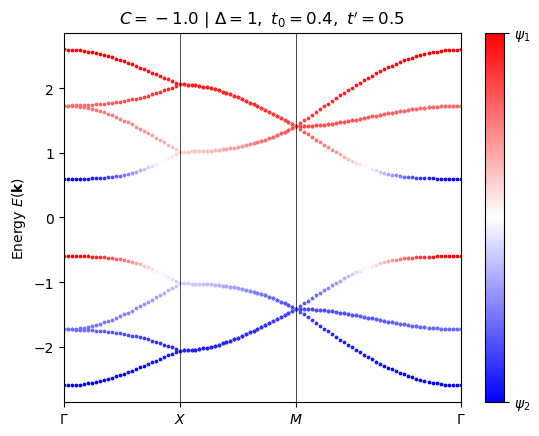

In [22]:
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")

fig, ax = plot.plot_bands(
    model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

In [23]:
omit_sites = 4
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site

In [24]:
nk = 101
(k_vec, k_dist, k_node) = model.k_path(k_path, nk, report=False)

evals, u_path = model.solve_all(k_vec, eig_vectors=True)
u_path = np.transpose(u_path, axes=(1,0,2)) # [*nk, n, orb]
psi_path = get_bloch_wfs(model, u_path, k_vec)
psi_tilde_int = get_psi_tilde(psi_path, tf_list)
u_tilde_int = get_bloch_wfs(model, psi_tilde_int, k_vec, inverse=True)

In [25]:
subspace = u_tilde_int
eigvals_sub, evecs_sub = diag_h_in_subspace(model, subspace, k_vec, ret_evecs=True)

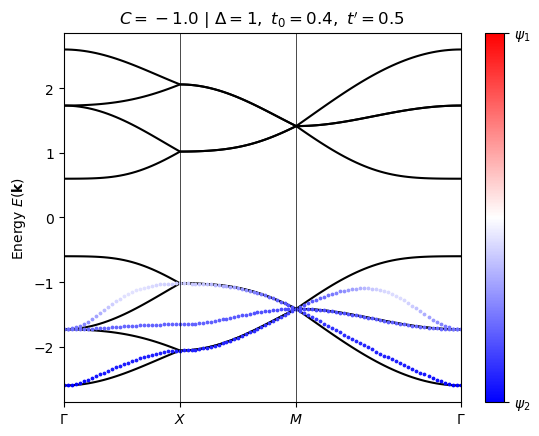

In [26]:
# Interpolated bands
fig, ax = plot.plot_bands(
    model, k_path, evals=eigvals_sub, evecs=evecs_sub, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

# Original bands
for n in range(evals.shape[0]):
    ax.plot(k_dist, evals[n], c='k', lw=1.5, zorder=0)

([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: >, <Axes: xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

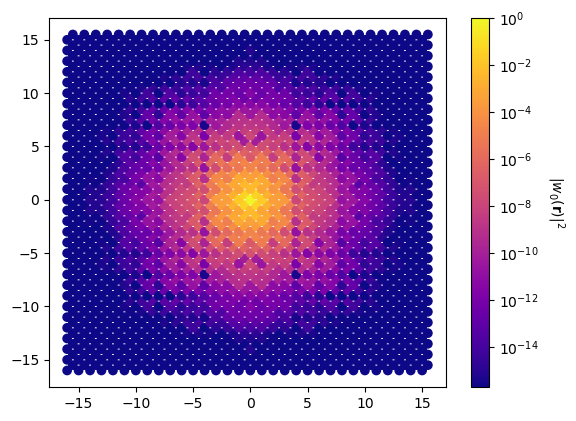

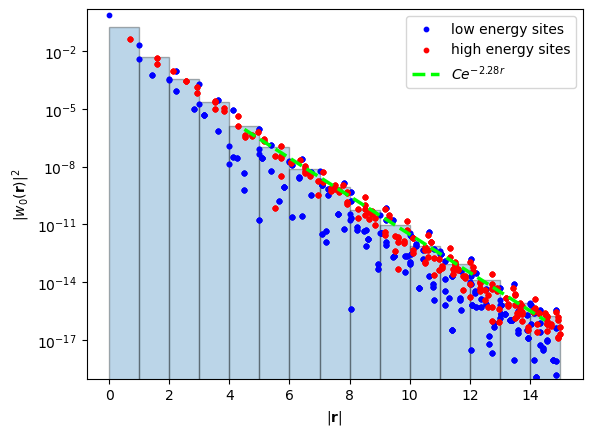

In [27]:
# 2D k-mesh
nkx = 16
nky = 16
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)

u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

w0, psi_til_wan = Wannierize(model, u_wfs_Wan, tf_list, ret_psi_til=True)
u_tilde_wan = get_bloch_wfs(model, psi_til_wan, k_mesh, inverse=True)

plot.plot_Wan(w0, 0, orbs, lat_vecs, plot_decay=True)

In [28]:
M = k_overlap_mat(u_wfs_Wan, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(model, M, decomp=True)

print(rf"Spread from M_kb of u_nk = {spread[0]}")
print(rf"Omega_I from M_kb of u_nk = {spread[1]}")
print(rf"Omega_til from M_kb of u_nk = {spread[2]}")

Spread from M_kb of u_nk = (1011.4811454344932+0j)
Omega_I from M_kb of u_nk = -1.43982048506075e-14
Omega_til from M_kb of u_nk = (1011.4811454344901+0j)


In [29]:
M = k_overlap_mat(u_tilde_wan, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(model, M, decomp=True)

print(rf"Spread from M_kb of \tilde{{u_nk}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde{{u_nk}} = {spread[1]}")
print(rf"Omega_til from M_kb of \tilde{{u_nk}} = {spread[2]}")

Spread from M_kb of \tilde{u_nk} = (0.8461633960951493+0j)
Omega_I from M_kb of \tilde{u_nk} = 0.7542011847776007
Omega_til from M_kb of \tilde{u_nk} = (0.09196221131753476+0j)


In [30]:
# spread, expc_rsq, expc_r_sq = spread_real(w0, orbs, lat_vecs, decomp=True)

# print(rf"Spread from w0 = {spread[0]}")
# print(rf"Omega_I from w0 = {spread[1]}")
# print(rf"Omega_tilde from w0 = {spread[2]}")

In [31]:
outer_states = u_wfs_Wan._wfs[..., :n_occ, :]
util_min_Wan = find_optimal_subspace(
    model, outer_states, u_tilde_wan, k_mesh=None, full_mesh=False, tol=2e-4, iter_num=3000)

0 Omega_I: 78.19051933852954, diff: 0.0014352200784832892
1 Omega_I: 1.429297801543418, diff: 0.00042593524835753127
2 Omega_I: 0.7565582177634868, diff: 0.027373553435877333
3 Omega_I: 0.7906845350320626, diff: 0.15113186650150917
4 Omega_I: 0.7576156495331096, diff: 0.14571117753819435
5 Omega_I: 0.7497332112352671, diff: 0.02664678327490425
6 Omega_I: 0.7456588442469121, diff: 0.05847036836760444
7 Omega_I: 0.7486079714089131, diff: 0.0665177912184719
8 Omega_I: 0.7417211377551347, diff: 0.010819149605721383
9 Omega_I: 0.7408304345835235, diff: 0.03460329203945828
10 Omega_I: 0.7417020174486776, diff: 0.04177442596588208
11 Omega_I: 0.7379441790069434, diff: 0.005475276370282659
12 Omega_I: 0.7368364037165922, diff: 0.023272195685169354
13 Omega_I: 0.7371938070946873, diff: 0.030071672909420193
14 Omega_I: 0.7345374432578546, diff: 0.002861455290110868
15 Omega_I: 0.7334702047081478, diff: 0.01698633545399987
16 Omega_I: 0.7335027955863718, diff: 0.023498078557015866
17 Omega_I: 0.7

In [32]:
M = k_overlap_mat(util_min_Wan, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(model, M, decomp=True)

print(rf"Spread from M_kb of \tilde{{u_nk}}_{{min}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde{{u_nk}}_{{min}} = {spread[1]}")
print(rf"Omega_til from M_kb \tilde{{u_nk}}_{{min}} = {spread[2]}")

Spread from M_kb of \tilde{u_nk}_{min} = (404.5481012112481+0j)
Omega_I from M_kb of \tilde{u_nk}_{min} = 0.6841938666494765
Omega_til from M_kb \tilde{u_nk}_{min} = (403.8639073445939+0j)


In [33]:
# eigvals_min, evecs_min = diag_h_in_subspace(model, util_min_path, k_vec, ret_evecs=True)

# fig, ax = plot.plot_bands(
#     model, k_path, evals=eigvals_min, evecs=evecs_min, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

# # continuous bands
# for n in range(evals.shape[0]):
#     ax.plot(k_dist, evals[n], c='k', lw=1.5, zorder=0)

In [34]:
psi_til_min = get_bloch_wfs(model, util_min_Wan, k_mesh)
state_idx = list(range(psi_til_min.shape[2]))
psi_til_til_min = get_psi_tilde(psi_til_min, tf_list, state_idx=state_idx)
u_til_til_min = get_bloch_wfs(model, psi_til_til_min, k_mesh, inverse=True)

M = k_overlap_mat(u_til_til_min, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(model, M, decomp=True)

print(rf"Spread from M_kb of \tilde\tilde{{u_nk}}_{{min}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde\tilde{{u_nk}}_{{min}} = {spread[1]}")
print(rf"Omega_til from M_kb of \tilde\tilde{{u_nk}}_{{min}} = {spread[2]}")

Spread from M_kb of \tilde\tilde{u_nk}_{min} = (0.7233799571900179+0j)
Omega_I from M_kb of \tilde\tilde{u_nk}_{min} = 0.6841938666494707
Omega_til from M_kb of \tilde\tilde{u_nk}_{min} = (0.039186090540546045+0j)


In [35]:
U, _ = find_min_unitary(model, M, iter_num=5000, eps=1e-2, print_=True)

0
Omega_til = (0.038918044860114465+0j)
Grad mag:  15.459751966097828
1
Omega_til = (0.03870961708929099+0j)
Grad mag:  15.167986198358756
2
Omega_til = (0.03854063874046551+0j)
Grad mag:  14.878608399709304
3
Omega_til = (0.03839967264288264+0j)
Grad mag:  14.5921963728993
4
Omega_til = (0.03827947026097895+0j)
Grad mag:  14.309176560683555
5
Omega_til = (0.03817518726940936+0j)
Grad mag:  14.029870713527744
6
Omega_til = (0.038083821017003916+0j)
Grad mag:  13.754521198629243
7
Omega_til = (0.038005993897654924+0j)
Grad mag:  13.483308505468784
8
Omega_til = (0.037961590514298184+0j)
Grad mag:  13.21636597369562
9
Omega_til = (0.038103782000514334+0j)
Grad mag:  12.953802533784634
10
Omega_til going up
Omega_til = (0.039558598607049314+0j)
Grad mag:  12.695796865701661
11
Omega_til going up
Omega_til = (0.05075618561782415+0j)
Grad mag:  12.443196148603725
12
Omega_til going up
Omega_til = (0.13632103153722092+0j)
Grad mag:  12.201508014256731
13
Omega_til going up
Omega_til = (0.801

KeyboardInterrupt: 

In [109]:
u_min = np.zeros(u_til_til_min.shape, dtype=complex)
for kx in range(nkx):
    for ky in range(nky):
        for i in range(u_min.shape[2]):
            for j in range(u_min.shape[2]):
                u_min[kx, ky, i, :] += U[kx, ky, j, i] * u_til_til_min[kx, ky, j] 

psi_min = get_bloch_wfs(model, u_min, k_mesh, inverse=False)

M = k_overlap_mat(u_min, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(model, M, decomp=True)

print(rf"Spread from M_kb of \tilde{{u_nk}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde{{u_nk}} = {spread[1]}")
print(rf"Omega_til from M_kb of \tilde{{u_nk}} = {spread[2]}")

Spread from M_kb of \tilde{u_nk} = (0.7196930165847619+0j)
Omega_I from M_kb of \tilde{u_nk} = 0.6828563312758302
Omega_til from M_kb of \tilde{u_nk} = (0.03683668530893598+0j)


([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: >, <Axes: xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

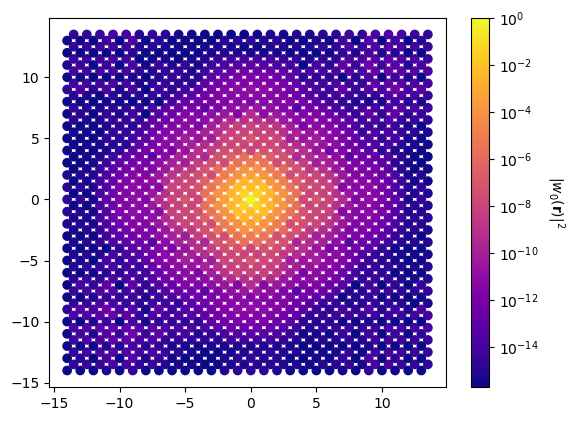

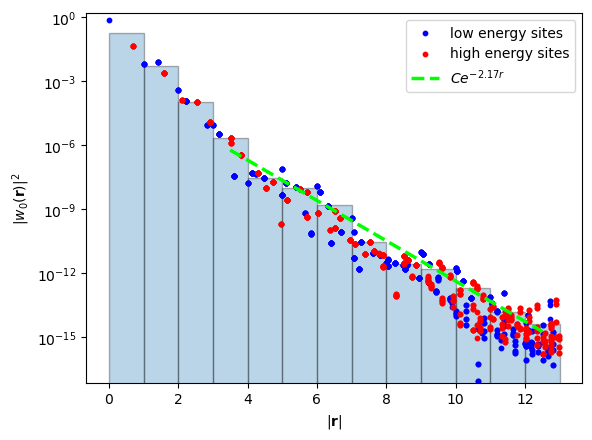

In [110]:
# dim_k = len(psi_til_til_min.shape[:-2])
# w0 = np.fft.ifftn(psi_til_til_min, axes = [i for i in range(dim_k)])
w0 = DFT(psi_min)
plot.plot_Wan(w0, 0, orbs, lat_vecs, plot_decay=True)

spread, expc_rsq, expc_r_sq = spread_real(model, w0, decomp=True)
print(rf"Omega_I from w0 = {spread[1]}")
print(rf"Omega_tilde from w0 = {spread[2]}")